<a href="https://colab.research.google.com/github/seungmei/ESAA_24_1/blob/main/0304(%EC%9B%94)_1%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_%ED%95%B8%EC%A6%88%EC%98%A8_Ch_3_%EB%B6%84%EB%A5%98_pg_127_154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0304(월) 1주차 과제 핸즈온 Ch.3 분류 pg127-154

### 3.1 MNIST
MNIST 데이터셋 - 많은 사람들이 숫자를 손으로 쓴 이미지 세트.

In [10]:
import numpy as np
import pandas as pd

In [21]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 사이킷런에서 읽어 들인 데이터셋들의 딕셔너리 구조
  - 데이터셋을 설명하는 DESCR키
  - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
  - 레이블 배열을 담은 target 키

In [22]:
X, y = mnist['data'], mnist['target']
X.shape
#이미지 70000개, 각 이미지마다 784개의 특성

(70000, 784)

In [23]:
y.shape

(70000,)

데이터셋에서 이미지 하나를 확인해보자

<function matplotlib.pyplot.show(close=None, block=None)>

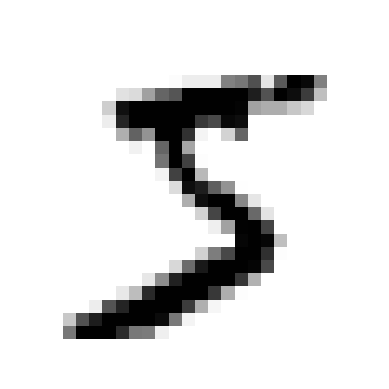

In [24]:
# 28x28 배열로 크기 변환. 맷플롯립의 imshow()함수를 사용
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show

In [25]:
y[0]

'5'

In [26]:
y = y.astype(np.uint8)

데이터에서 항상 테스트 세트를 만들고 따로 떼어놓아야...
But, MNIST는 이미 훈련 세트와 테스트 세트로 나누어져 있음.

In [27]:
#모든 교차 검증 폴드를 비슷하게 만듦. 데이터셋을 섞기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련 Binary Classifier
'5-감지기': '5'/'5' 아님 감지

In [31]:
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 False
y_test_5 = (y_test == 5)

- SGDClassifier(Stochastic Gradient Descent)
  - 매우 큰 데이터셋 효율적으로 처리하는 장점
  ∵ 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
  - 훈련하는데 무작위성 사용.


SGD 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜보자.

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [36]:
sgd_clf.predict([some_digit])
#분류기가 해당 이미지가 5를 나타낸다고 추측

array([ True])

### 3.3 성능 측정
#### 3.3.1 교차 검증을 사용한 정확도 측정
*사이킷런 제공 기능보다 교차 검증을 많이 제어해야 한다면? 교차 검증 기능을 직접 구현할 것!*

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correst = sum(y_pred == y_test_fold)
  print(n_correst / len(y_pred))

0.95035
0.96035
0.9604


In [39]:
#cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 모델 평가

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train-5, cv=3, scoring='accuracy')

array([0.88395, 0.8625 , 0.8805 ])

In [40]:
#더미 분류기로
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [41]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
#정확도가 90% 이상이지만, 이미지의 10%만 숫자 5이기 때문에 무조건 5아님으로 예측하면 90% 정확도

array([0.91125, 0.90855, 0.90915])

이러한 이유로 인해 "정확도"를 성능 측정 지표로 선호하지 않는다.
특히, 불균형한 데이터셋을 다룰 때

#### 3.3.2 오차 행렬 confusion matrix:
클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [42]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predict():
k-겹 교차 검증 수행. 평가 점수 반환X. 각 테스트 폴드에서 얻은 예측 반환.
⇒ 훈련 세트의 모든 샘플에 대해 깨끗한 예측.

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# true negative, false positive : negative class
# false positive, true positive : positive class

array([[53892,   687],
       [ 1891,  3530]])

- 오차 행렬
  - 행: 실제 클래스
  - 열: 예측 클래스

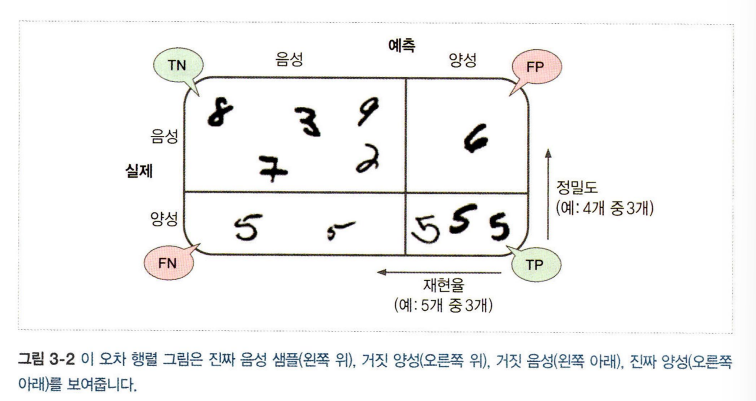

In [45]:
y_train_prefect_predictions = y_train_5 #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도 precision:
TP/(TP+FP) (양성 예측 中 진짜 양성)
- 재현율 recall:
TP/(TP+FN) (실제 양성 中 예측도 양성)

#### 3.3.3 정밀도와 재현율


In [46]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 /(4096 + 1522)

0.8370879772350012

In [47]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

- F1 score:
정밀도와 재현율의 조화 평균
  - 상황에 따라 정밀도가 중요할 수도 재현율이 중요할 수도. 둘다 얻을 수는 없음.:
  정밀도/재현율 트레이드오프

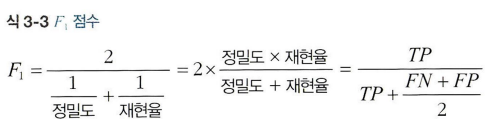

In [48]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

#### 3.3.4 정밀도/재현율 트레이드오프

- SGDCLassifier는 결정함수 사용 → 각 샘플 점수 계산.
  - 점수 ＞ 임계값 ==> 양성 클래스
  - if not, 음성 클래스

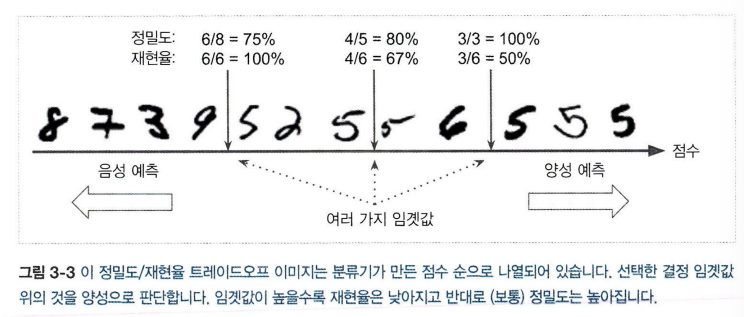

In [49]:
# 예측에 사용한 점수 확인 가능
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [52]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [54]:
#임곗값 높이기 ==> 재현율 ↓
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [55]:
#적절한 임곗값 어떻게?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [57]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

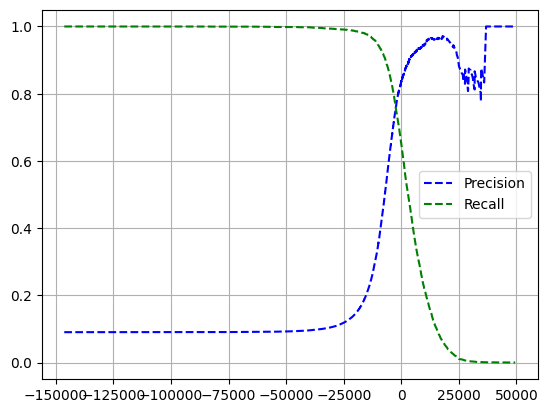

In [59]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.grid(True)
plt.show()

In [61]:
#정밀도 90%달성이 목표라면? 그래프에서 임곗값이 8000정도
threshold_90_precision = thresholds[np.argmax(precisions > 0.90)] #~7816

In [62]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [63]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [64]:
recall_score(y_train_5, y_train_pred_90)
# 정밀도 90%인 분류기임을 확인

0.4799852425751706

#### 3.3.5 ROC 곡선:
(진짜 양성 비율) / (거짓 양성 비율)
* tpr ↑ ==> fpr ↑
* 왼쪽 위 모서리일수록, the better

In [65]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

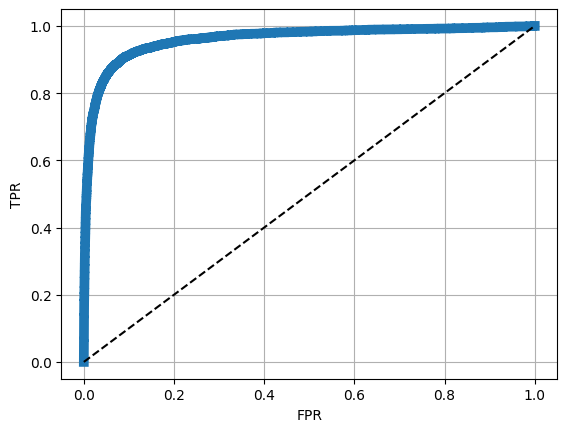

In [75]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=7, label=label)
  plt.plot([0,1], [0,1],'k--') #대각 점선
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

- 곡선 아래의 면적(Area Under the Curve) 측정
  - 완벽 분류기: AUC = 1
  - 완전 랜덤 분류기 : AUC = 0.5

In [76]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- 양성 클래스가 드물다. or 거짓 양성이 더 중요 ==> PR곡선
- if not, ROC 곡선

RandomForestClassifier 훈련시켜 SGDClassifier의 ROC곡선과 AUC 점수 비교

In [77]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [69]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

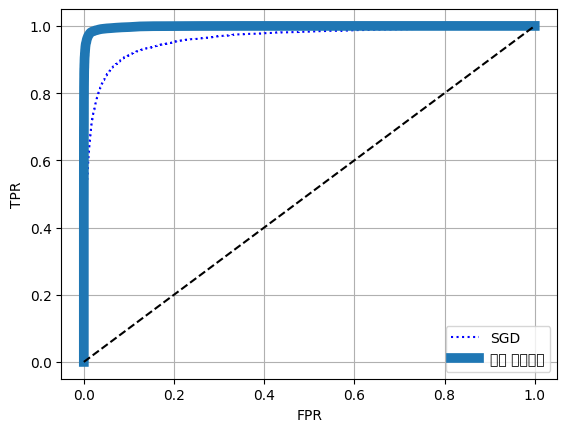

In [78]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#### 3.4 다중 분류:
둘 이상의 클래스 구별 可
  - 일부 알고리즘: 여러개 클래스 직접 처리
  - 다른 알고리즘: 이진 분류(이진분류기를 여러개 사용 --> 다중 클래스 분류 기법도 존재)
  -OvR(OvA): 분류 시 결정 점수 중에서 가장 높은 것을 클래스로 선택.

In [80]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5 아님 ∵ 다중 클래스
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [83]:
np.argmax(some_digit_scores)

5

In [82]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [84]:
svm_clf.classes_[5]

5

사이킷런에서 OvO, OvR 사용 강제 <-- OneVsOneClassifier, OneVsRestClassifier

In [85]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [86]:
len(ovr_clf.estimators_)

10

SGDClassifier 훈련

In [87]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [88]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 분류기 평가는 일반적으로 교차 검증 사용

In [89]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#### 3.5 에러 분석


In [91]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

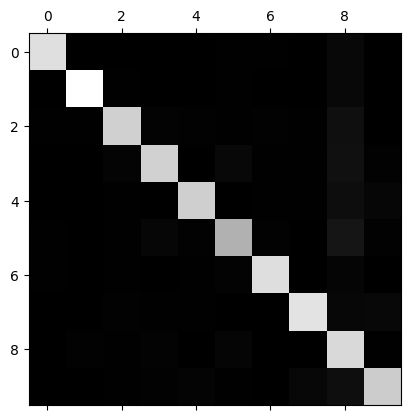

In [92]:
#오차행렬 이미지
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [93]:
#그래프의 에러부분에서
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누기 --> 에러비율 계산
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

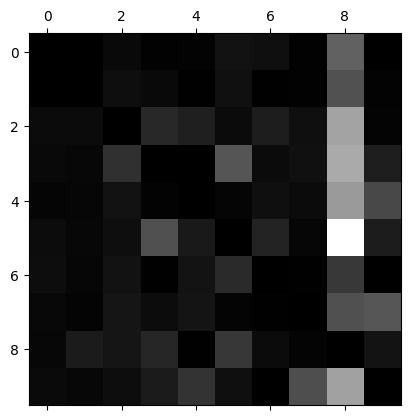

In [94]:
#주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#많은 이미지가 클래스 8로 잘못 분류되었음.
#8행을 보면 그다지 나쁘지 않음. 실제 8이 적절히 8로 분류됨.

In [95]:
#plot_digits()
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

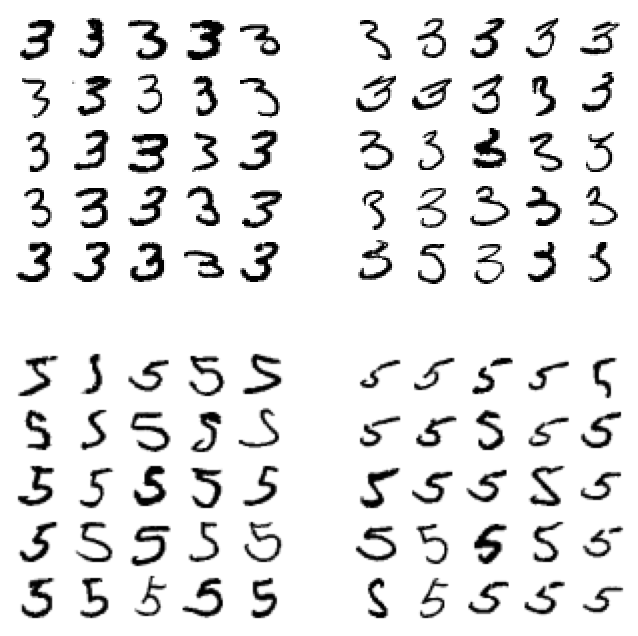

In [96]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

대부분의 잘못 분류된 이미지의 원인이 무엇?
∵선형 모델을 사용했기 때문! --> 픽셀 강도의 가중치 합을 클래스의 점수로 계산. & 3, 5는 몇 개의 픽셀만 다름.

### 3.6 다중 레이블 분류:
사진 한장에 인식된 사람마다 하나씩 꼬리표tag 달기
- 평가하는 방법: 다양. F1 구하기 등.

In [97]:
# 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [98]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [99]:
#모든 레이블에 대한 F1 점수의 평균
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### 3.7 다중 출력 분류:
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화. (값 두개이상 가지기 可)

잡음 제거하는 시스템을 만들어보자

In [100]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [102]:
#knn_clf.fit(X_train_mod, y_train_mod)
#clean_digit = knn_clf.predict([X_test_mod[some_index]])
#plot_digit(clean_digit)

NameError: name 'some_index' is not defined